# Simulating A Pendulum's Motion

Inspired largely by [this video](https://youtu.be/p_di4Zn4wz4) on differential equations by 3Blue1Brown. In this notebook, we model the motion of a pendulum using a differential equation and then simulate it using Python scientific computing tools.

In [1]:
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from IPython.display import HTML
%matplotlib notebook

## The Pendulum Equation

One of the beauties of differential equations is how easy it is to go from a physical description of the system to a model for of how the system behaves. One way to describe a physical system is by drawing a Free Body Diagram, or FBD. A Free Body Diagram outlines all of the forces acting on an object as arrows on a diagram.



Analyzing this FBD, we see that the pendulum is influenced by two forces. First, there's the force of gravity, which equals the mass of the object times acceleration due to gravity ($F_g = mg$), and always acts downward. In this case, downward is represented as a negative number $-F_g$. However, the pendulum can only move across the arc defined by the angle $\theta$. So, the only component of the force that influences the pendulum is along the direction of this arc. As the FBD shows, this direction is along $\sin{\theta}$. So, our first force is $F_g \sin{\theta} = -mg\sin{\theta}$.

The second component is the drag force $F_D$. This is usually modeled as proportional to the velocity of the system and acts in the opposite direction of velocity. In this case, velocity is proportional to the change in the angle (or angular velocity) by $L$. We can define a coefficient $b$ to be the drag coefficient of this system. As drag acts in the opposite direction to velocity, this will also be negative. So the final equation for drag force is $F_D = -bL\dot{\theta}$

Our final force equation is the following:

$$
\Sigma F = - mg \sin{\theta} - bL \dot{\theta}
$$

Newton's Second Law states that the net force on an object is equal to the mass times the acceleration. Acceleration is modeled as proportional to the change in angular velocity $\ddot{\theta}$ by the length $L$. The equation then becomes the following

$$
m L \ddot{\theta} = - mg \sin{\theta} - bL \dot{\theta}
$$

Rearranging, we get our final equation

$$
\ddot{\theta} = - \frac{g}{L} \sin \theta - \frac{b}{m} \dot{\theta}
$$

Now, there's no real way to model second order differential equations, but, this can actually be broken up into a system of first order equations. We do so by treating the velocity $\dot{\theta}$ as a separate, free variable, which we will now call $\omega$. So now we have two variables, $\theta$ and $\omega$. We consider the first order derivatives of these variables. $\dot{\theta}$ is already defined as $\omega$. We also can determine $\dot{\omega}$, by our definition, to be $\ddot{\theta}$, which is defined by our differential equation.

So our system of equations is now the following:

$$
\begin{aligned}
    \dot{\theta} &= \omega \\
    \dot{\omega} &= - \frac{g}{L} sin(\theta) - \frac{b}{m} \omega
\end{aligned}
$$

If we write this in vectorized form

$$
\begin{bmatrix}
    \dot{\theta} \\
    \dot{\omega}
\end{bmatrix} = \begin{bmatrix}
    \omega \\
    -\frac{g}{L} sin(\theta) -\frac{b}{m} \omega
\end{bmatrix}
$$

We can now write this equation as a python function which will help our analysis

In [2]:
def pendulum(t, Th, g=9.81, L=1, m=3, b=0.5):
    """
    Pendulum differential equation
    """
    th, om = Th
    omd =  - (b/m) * om - (g/L) * np.sin(th)
    out = np.array([ om, omd ])
    return out

## Phase Plot of Equation

Differential equations can be better analyzed in phase space. A phase space is an abstract space where the dimensions are the position and velocity components of the system. Each position in the space represents a unique state that the pendulum could be in. The model equation is represented as a vector valued function that shows the direction that the pendulum system will travel next in this space. Given a position in the space, the phase diagram shows the next position, and then the next position after that. So the plot will be a vector plot with the x axis representing the angle of the pendulum and the y axis representing the angular velocity of the pendulum.

<IPython.core.display.Javascript object>


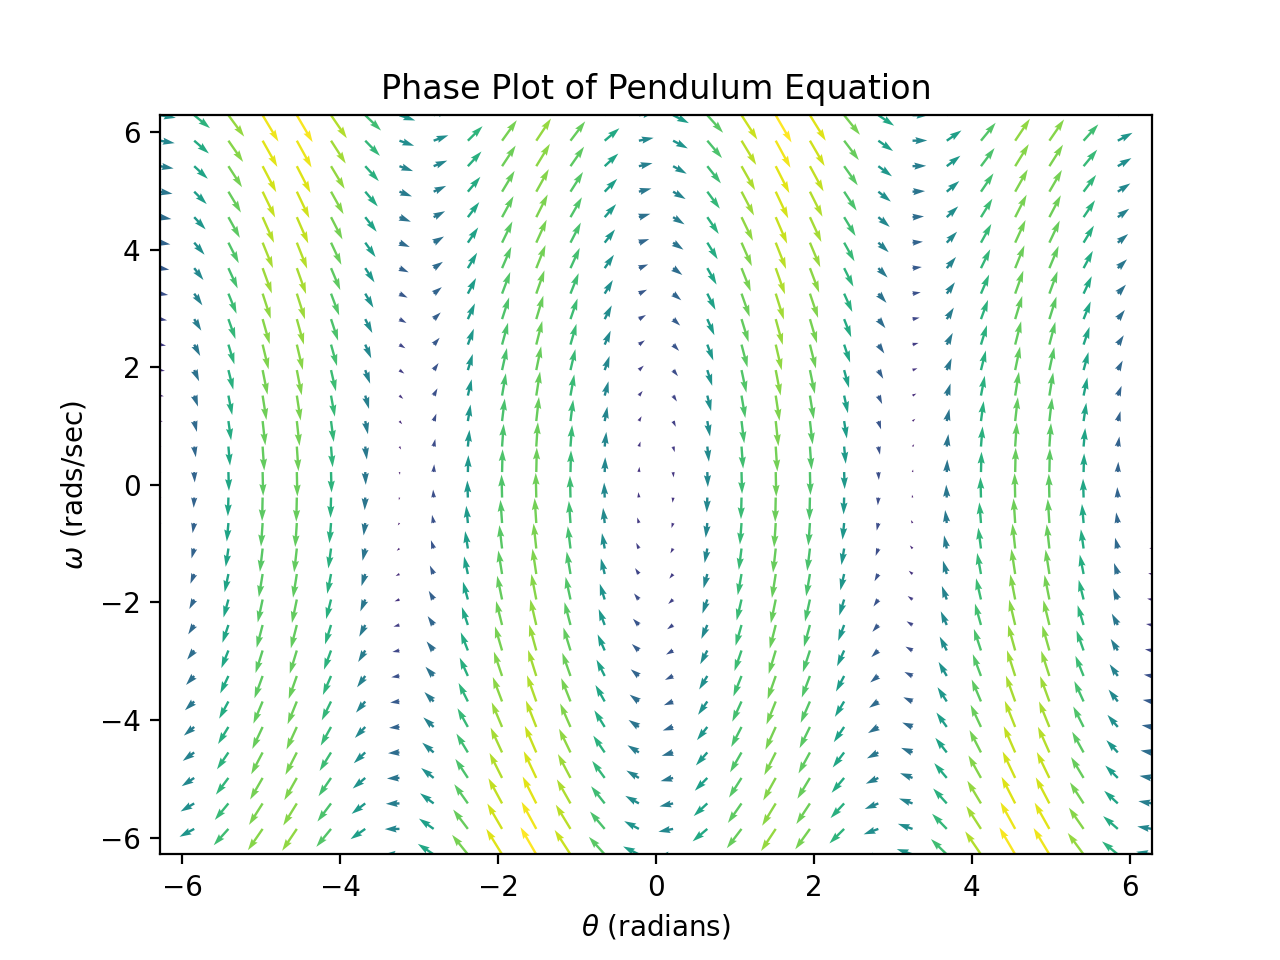

In [3]:
thr, omr = np.meshgrid(
    np.linspace(-2*np.pi, 2*np.pi, 30),
    np.linspace(-2*np.pi, 2*np.pi, 30)
)
thv, omv = pendulum(0.0, [thr, omr])
plt.figure()
plt.quiver(thr, omr, thv, omv, np.hypot(thv, omv))
plt.xlabel('$\\theta$ (radians)')
plt.ylabel('$\omega$ (rads/sec)')
plt.title('Phase Plot of Pendulum Equation')
plt.axis([ -2*np.pi, 2*np.pi, -2*np.pi, 2*np.pi ])
plt.show()

## Generate Phase Flows using `scipy.integrate`

As it's not possible to solve the equation analytically, the way to solve the equation is by starting at a starting value and programmatically incrementing this variable using the differential equation, generating an array of variables along a path. This is called numerically solving the equation. One thing about differential equations is that they will respond differently given different initial value. A differential equation together with an initial value is called an initial value problem. In this case, multiple initial values were tested at once. Integration of initial value problems can be done using Scipy's `solve_ivp` function.

<IPython.core.display.Javascript object>


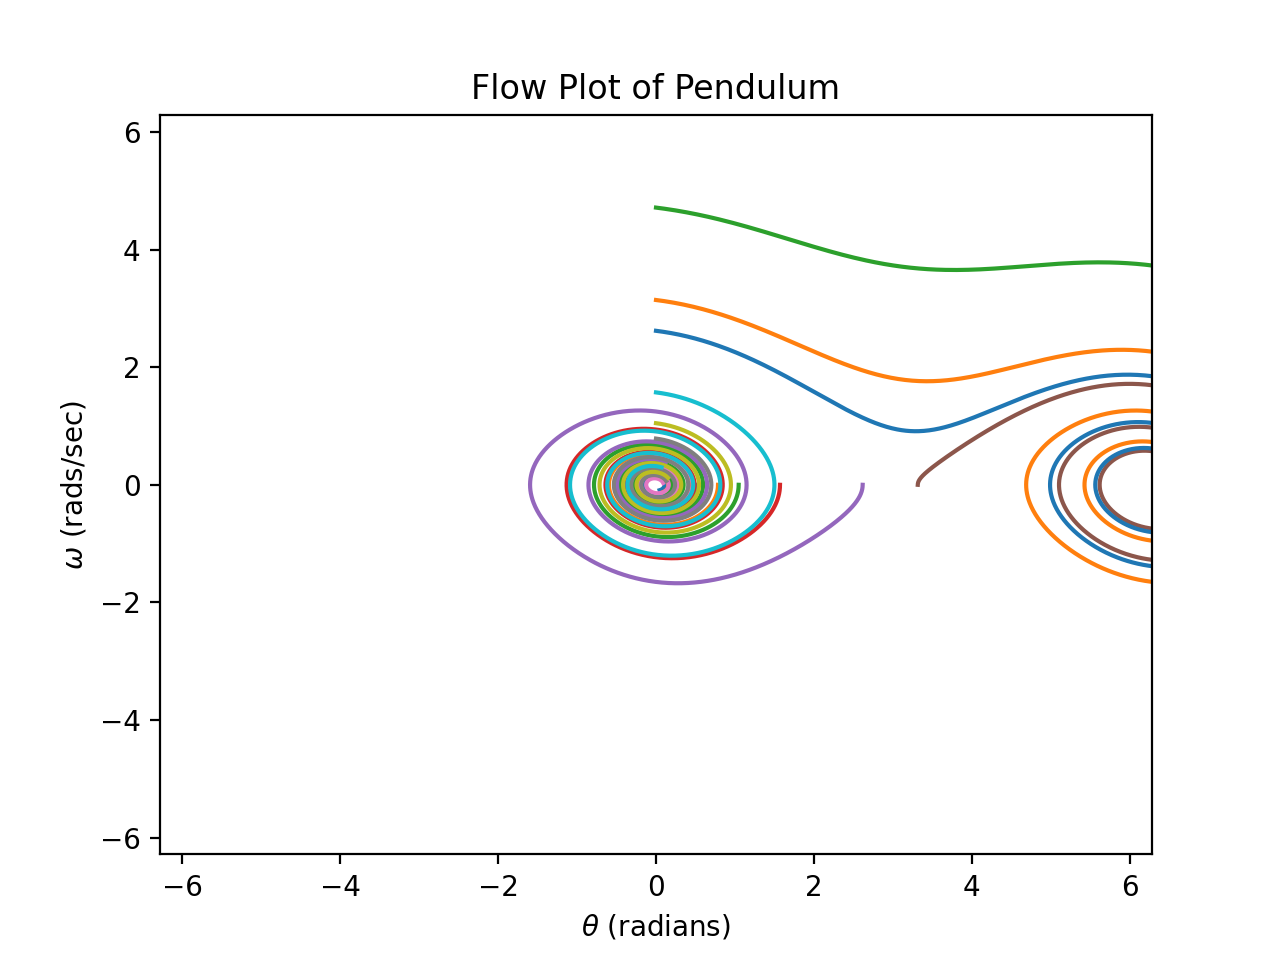

In [4]:
# Equation meta parameters
L = 10
g = 9.81
m = 3
b = 0.5

# Time span
t = (0, 20)
max_dt = 0.01

# Initial parameters
Th0s = np.radians([
    [  30,   0 ],
    [  45,   0 ],
    [  60,   0 ],
    [  90,   0 ],
    [ 150,   0 ],
    [ 190,   0 ],
    [   0,  30 ],
    [   0,  45 ],
    [   0,  60 ],
    [   0,  90 ],
    [   0, 150 ],
    [   0, 180 ],
    [   0, 270 ]
])

# Do all the integrations
Ths = [
    spi.solve_ivp(
        pendulum, 
        t, Th0, 
        max_step=max_dt, 
        args=(L, g, m, b)).y
    for Th0 in Th0s ]

# Plot them all!
plt.figure()
for Th in Ths:
    plt.plot(Th[0], Th[1])
plt.axis([-2*np.pi, 2*np.pi, -2*np.pi, 2*np.pi])
plt.xlabel('$\\theta$ (radians)')
plt.ylabel('$\\omega$ (rads/sec)')
plt.title('Flow Plot of Pendulum')
plt.show()

## Simulate Multiple Pendulums

Now for the fun part. Using this equation, we can animate a simulation of pendulums using matplotlib's animation.

Programmer's Note: I was planning on using Scipy's ODE integration system. However, I wanted to be able to simulate multiple pendulums using my differential equation, which can work with numpy arrays of intitial values. It appears that the ODE integration system doesn't really work with arrays of more than 1D. Luckily, we can manually integrate the equation and draw each step, which is what was done here.

In [6]:
# Initial parameters
Th0 = np.radians([
    # Initial angles
    [ 30,  60,  90, 190,   0,   0,   0,   0,   0],
    # Initial angular velocities
    [  0,   0,   0,   0,  30,  60,  90, 180, 270]
])

# Equation meta parameters
L = 10
g = 9.81
m = 3
b = 0.5

# Figure parameters
interval = 20
framerate = 30
size = 15

# Turning interactive plot off temporarily
plt.ioff()

# Plot dimensions
dims = 8, 6
ylim = -size, size
xsize = size * dims[0] / dims[1]
xlim = -xsize, xsize

# Create figure
fig = plt.figure(figsize=dims)
ax = plt.axes(xlim=xlim, ylim=ylim)
plt.xticks([])
plt.yticks([])
plt.title('Pendulum Simulation!')

# Get lines in which to plot pendulums
lines = [
    ax.plot([], [], lw=1, marker='o')[0]
    for i in range(Th0.shape[1])
]

def init():
    """
    Initialization function
    """
    for line in lines:
        line.set_data([], [])
    return lines

Th = Th0
def animate(i):
    """
    Animation function
    """
    # Define our global pendulum variable
    global Th
    dt = 1/framerate
    
    # Update pendulum state
    Th += pendulum(t, Th, g, L, m, b)*dt
    
    # Get x and y components
    th = Th[0,:]
    x = L*np.sin(th)
    y = -L*np.cos(th)
    
    # Draw each pendulum
    for line, xi, yi in zip(lines, x, y):
        line.set_data([0, xi],[0, yi])
        
    # Return updated lines
    return lines

# Generate animation
frames = interval*framerate
anm = anim.FuncAnimation(
    fig, animate,
    init_func=init,
    interval=interval,
    frames=frames,
    blit=True)

# Close plot
plt.close(fig)
plt.ion()

# Render animation
HTML(anm.to_html5_video())